In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
from glob import glob
from tqdm import tqdm

In [2]:
train_path='dataset1/train'

In [3]:
train_images=[]
train_masks=[]
def load_images(path):
    temp_img,temp_mask=[],[]
    images=glob(os.path.join(path,'*.jpg'))
    for i in tqdm(images):
        i=cv2.imread(i)
        i=cv2.normalize(i,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=i[:,:256]
        msk=i[:,256:]  
        #img = cv2.resize(img,(64,64))
        #msk = cv2.resize(msk,(64,64))
        temp_img.append(img)
        temp_mask.append(msk)
        cv2.imwrite("image.jpg",msk)
    return temp_img,temp_mask

train_images,train_masks=load_images(train_path)

100%|█████████████████████████████████████████████████████████████████████████████| 3475/3475 [00:08<00:00, 412.04it/s]


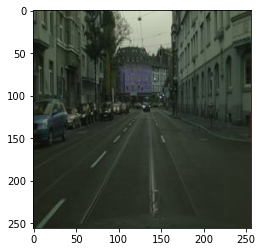

In [4]:
plt.imshow(train_images[3])

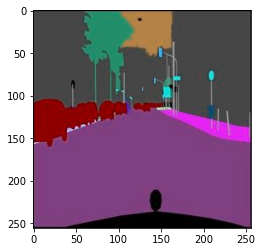

In [5]:
plt.imshow(train_masks[3])

In [6]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [9]:
from sklearn.model_selection import train_test_split

trainx, testx, trainy, testy = train_test_split(train_images, train_masks, test_size=0.2, random_state=40)
print(trainx.shape, testx.shape, trainy.shape, testy.shape)

(2780, 256, 256, 3) (695, 256, 256, 3) (2780, 256, 256, 3) (695, 256, 256, 3)


In [11]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(trainy)
print(train_masks_cat.shape)

(2780, 256, 256, 3, 2)


In [12]:
from tensorflow.keras.utils import to_categorical
test_masks_cat = to_categorical(testy)
print(test_masks_cat.shape)

(695, 256, 256, 3, 2)


In [13]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet, FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [14]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [17]:
trainx = preprocess_input(np.array(train_masks_cat))
testx = preprocess_input(np.array(test_masks_cat))

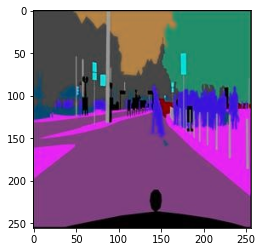

In [18]:
plt.imshow(trainy[1])

In [20]:
N = train_images.shape[-1]

base_model = Unet(backbone_name='inceptionv3', encoder_weights='imagenet',classes=2)
inp = Input(shape=(256,256,N))
l1 = Conv2D(3,(1,1))(inp)
l11 = Conv2D(3,(1,1))(l1)
out = base_model(l11)
l2 = Conv2D(3,(1,1))(out)
model = Model(inp,l2,name=base_model.name)

model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

# pretrain model decoder
model.fit(trainx, trainy, batch_size=8, epochs = 2, validation_data = (testx, testy))

for layer in model.layers:
    layer.trainable = True  # Freeze the layer

Epoch 1/2


ValueError: in user code:

    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv2d_97 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 256, 256, 3, 2)


In [ ]:
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
def dice_coefficient(y_true,y_pred):
    numerator = 2*tf.reduce_sum(y_true*y_pred)
    denominator = tf.reduce_sum(y_true+y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) - tf.math.log(dice_coefficient(y_true,y_pred) + tf.keras.backend.epsilon())

In [ ]:
#model.compile('Adam', loss=loss, metrics=[dice_coefficient])
#model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
model.compile('Adam', loss = bce_jaccard_loss, metrics=[dice_coefficient])

In [ ]:
model.fit(trainx, trainy, batch_size=8, epochs = 1, validation_data = (testx, testy))

In [ ]:
model.evaluate(testx,testy,verbose=1)

In [ ]:
out = model.predict(np.expand_dims(testx[10],axis=0))[0]
plt.imshow((out * 255).astype(np.uint8))

In [ ]:
plt.imshow((trainx[10] * 255).astype(np.uint8))